In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [33]:
tweetPath = '/content/drive/MyDrive/interIIT/dev_data_tweet.xlsx'
articlePath ='/content/drive/MyDrive/interIIT/dev_data_article.xlsx' 

In [34]:
tweets = pd.read_excel(tweetPath)
tweets.describe()

,Mobile_Tech_Tag
count,4000.000000
mean,0.250000
std,0.433067
min,0.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,1.000000


In [35]:
articles = pd.read_excel(articlePath)
articles.describe()

,Mobile_Tech_Flag
count,4000.000000
mean,0.243500
std,0.429248
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [36]:
tweets.head()

,Tweet_ID,Tweet,Mobile_Tech_Tag
0,tweet_0001,You'll 💜 my #PitchWars book if you like: 🦋 hat...,0
1,tweet_0002,RT @SkySportsNews: 🚨 Breaking: #WBA have reach...,0
2,tweet_0003,RT @stealyoman_cuso: really says a lot about s...,0
3,tweet_0004,RT @PGtzsche1: HPV vaccines increased serious ...,0
4,tweet_0005,Ramaphosa says if you are positive you must se...,0


In [37]:
articles.head()

,Text_ID,Text,Headline,Mobile_Tech_Flag
0,article_0001,Digitisation is one of the key buzzwords in th...,Pakistan’s digital landscape post-Covid,0
1,article_0002,Increase in tolerance limit up to 120 per cent...,Affordable housing gets shot in the arm,0
2,article_0003,Home > News > World Sports News\n\nJonas Lossl...,Jonas Lossl leaves Everton to rejoin first clu...,0
3,article_0004,"Source: Agfax.com\n\nBy Keith Brown, DTN Contr...",DTN Cotton Closing: Cotton Higher on Commoditi...,0
4,article_0005,"United Nations, Feb 4: The Serum Institute of ...","Serum Institute of India, UNICEF enter into lo...",0


In [38]:
articles['Mobile_Tech_Flag'].value_counts()

0    3026
1     974
Name: Mobile_Tech_Flag, dtype: int64

In [39]:
newData = articles.drop('Headline',axis=1)
newtweet = pd.DataFrame({
    'Text_ID': tweets['Tweet_ID'],
    'Text': tweets['Tweet'],
    'Mobile_Tech_Flag': tweets['Mobile_Tech_Tag']
})
newData = newData.append(newtweet)

In [40]:
word = ['QT','RT']

In [41]:
import re
import string
def preprocessingText(text):
  text = re.sub(r'http\S+', '',text)
  text = re.sub(r'\s([@][\w_-]+)', '', text).strip()
  text = ''.join([i for i in text if i not in string.punctuation])
  text = ' '.join([i for i in text.split() if i not in word]).strip()
  return text
X = newData.iloc[6,1]
print('Original text :', X)
print('Processed Word :', preprocessingText(X))

Original text : Poverty-centred local adaptation in Mozambique

Social protection systems aim to eradicate poverty but often only reach a minority of the poorest households. Those eligible for social protection are often vulnerable to climate impacts that risk driving them further into poverty. Mabote district, Mozambique, is susceptible to ‘slow onset’ climate shocks, particularly droughts, which exacerbate food insecurity. Social protection reaches just 15% of poor households there. The PRIORIZE Initiative (a three-year programme) worked at district level in Mabote district to align social protection with climate adaptation, adopting a variant of the ‘adaptive social protection’ approach — what we call ‘poverty-centred local adaptation’ (PCLA). This publication reflects on key learnings from the PRIORIZE Initiative and explores the way forward.
Processed Word : Povertycentred local adaptation in Mozambique Social protection systems aim to eradicate poverty but often only reach a mino

In [42]:
newData['Text'] = newData['Text'].apply(lambda x : preprocessingText(x))

In [43]:
X = newData.Text.values
Y = newData.Mobile_Tech_Flag.values
X_train, X_val, y_train, y_val =\
    train_test_split(X, Y, test_size=0.1, random_state=2020)

In [44]:
np.unique(y_train)

array([0, 1])

In [45]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [46]:
!pip install transformers

In [47]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  
            add_special_tokens=True,        
            max_length=MAX_LEN,             
            pad_to_max_length=True,         
            #return_tensors='pt',           
            return_attention_mask=True   
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [48]:
type(X_train)

numpy.ndarray

In [49]:
all_tweets = newData.Text.values

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (793 > 512). Running this sequence through the model will result in indexing errors


Max length:  17469


In [50]:
MAX_LEN = 300

token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Digitisation is one of the key buzzwords in the postCovid world Digitisation is one of the key buzzwords in the postCovid world From online shopping for basic commodities to the digitisation of banking transactions Pakistan has shifted towards an online mode The pandemic has revealed the real potential of digital payments and mobile wallets and the current environment provides an excellent opportunity for fintechs to operate and ramp up their contribution to the country’s gross domestic product GDP growth The State Bank of Pakistan SBP is also strongly driving the initiative and has recently launched a micropayments gateway named Raast designed to ensure financial inclusion for the masses and trigger a wave of digital payments
Token IDs:  [101, 15340, 6648, 2003, 2028, 1997, 1996, 3145, 12610, 22104, 1999, 1996, 2695, 3597, 17258, 2088, 15340, 6648, 2003, 2028, 1997, 1996, 3145, 12610, 22104, 1999, 1996, 2695, 3597, 17258, 2088, 2013, 3784, 6023, 2005, 3937, 21955, 2000, 199

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [51]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [52]:
%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [53]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [54]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [55]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.358727   |     -      |     -     |   19.80  
   1    |   40    |   0.203383   |     -      |     -     |   18.80  
   1    |   60    |   0.182706   |     -      |     -     |   18.77  
   1    |   80    |   0.156203   |     -      |     -     |   18.78  
   1    |   100   |   0.141154   |     -      |     -     |   18.78  
   1    |   120   |   0.125146   |     -      |     -     |   18.73  
   1    |   140   |   0.135937   |     -      |     -     |   18.75  
   1    |   160   |   0.099914   |     -      |     -     |   18.74  
   1    |   180   |   0.106869   |     -      |     -     |   18.74  
   1    |   200   |   0.080596   |     -      |     -     |   18.77  
   1    |   220   |   0.086594   |     -      |     -     |   18.77  
   1    |   224   |   0.050357   |     -      |     -     |   3.75   


In [56]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [57]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [58]:
probs = bert_predict(bert_classifier, val_dataloader)

AUC: 0.9959
Accuracy: 97.75%


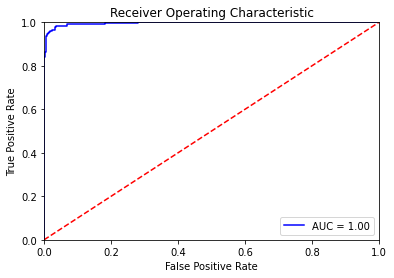

In [61]:
evaluate_roc(probs, y_val)

In [62]:
# !unzip '/content/drive/MyDrive/interIIT/samsung_mobile_new.csv.zip' -d '/content/drive/MyDrive/interIIT'

Archive:  /content/drive/MyDrive/interIIT/samsung_mobile_new.csv.zip
  inflating: /content/drive/MyDrive/interIIT/samsung_mobile_new.csv  


In [66]:
!unzip '/content/drive/MyDrive/interIIT/train.csv.zip' -d '/content/drive/MyDrive/interIIT'

Archive:  /content/drive/MyDrive/interIIT/train.csv.zip
  inflating: /content/drive/MyDrive/interIIT/train.csv  


In [65]:
mobiledata = pd.read_csv('/content/drive/MyDrive/interIIT/samsung_mobile_new.csv')
mobiledata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64078 entries, 0 to 64077
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Tweet Posted Time (UTC)  64078 non-null  object 
 1   Tweet Content            64078 non-null  object 
 2   Tweet Type               64078 non-null  object 
 3   Retweets Received        64078 non-null  object 
 4   Likes Received           64078 non-null  object 
 5   User Followers           64078 non-null  object 
 6   User Following           64077 non-null  float64
dtypes: float64(1), object(6)
memory usage: 3.4+ MB


In [69]:
mobData = pd.DataFrame({
    'Text': mobiledata['Tweet Content'][:2500],
}) 
mobData['Mobile_Tech_Flag'] = 1

In [73]:
nonmobiledata = pd.read_csv('/content/drive/MyDrive/interIIT/train.csv')
nonmobData = pd.DataFrame({
    'Text':nonmobiledata['text'][:2500]
})
nonmobData['Mobile_Tech_Flag'] = 0
evalData = mobData.append(nonmobData)

In [79]:
evalData.reset_index(drop=True,inplace=True)

In [78]:
evalData['Text'] = evalData['Text'].apply(lambda x : preprocessingText(str(x)))

In [81]:
from sklearn.utils import shuffle
X_v,Y_v = shuffle(evalData.Text.values,evalData.Mobile_Tech_Flag.values)

In [82]:
v_inputs, v_masks = preprocessing_for_bert(X_v)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [83]:
v_labels = torch.tensor(Y_v)
v_data = TensorDataset(v_inputs, v_masks, v_labels)
v_sampler = SequentialSampler(v_data)
v_dataloader = DataLoader(v_data, sampler=v_sampler, batch_size=batch_size)

In [84]:
probs = bert_predict(bert_classifier, v_dataloader)

In [86]:
probs.shape

(5000, 2)

AUC: 0.9927
Accuracy: 97.62%


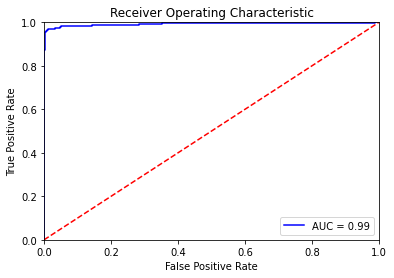

In [87]:
evaluate_roc(probs, Y_v)